# MLB Stats Project 
## Examining variables' effect on Major League Basball game's run totals 

First, let's import necessary libraries, import our data, and preview our dataframe. 

In [24]:
import query_helper
import pandas as pd 
import charlie_functions
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.api import OLS

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [25]:
df = pd.read_csv('/Users/schlinkertc/Flatiron/projects/MLB_Stats/MLB_Data.csv',index_col=0)
df['game_date'] = df['game_date'].map(lambda x:pd.to_datetime(x))

Our data has 11 columns and about 26,000 rows. It represents every completed regular season MLB game in the last 10 years.

In [26]:
display(df.head())
df.shape

,gameid,run_total,venue_name,home_team,away_team,game_date,status,temp,weather_category,division,league
0,244193,5,Citizens Bank Park,Philadelphia Phillies,Atlanta Braves,2009-04-05,Final,60,clear,NL_east,NL
1,244194,6,Minute Maid Park,Houston Astros,Chicago Cubs,2009-04-06,Final,66,roof closed,AL_west,AL
2,244195,10,Rangers Ballpark in Arlington,Texas Rangers,Cleveland Indians,2009-04-06,Final,49,sunny,AL_west,AL
3,244196,17,Chase Field,Arizona Diamondbacks,Colorado Rockies,2009-04-06,Final,80,roof closed,NL_west,NL
4,244197,17,Rogers Centre,Toronto Blue Jays,Detroit Tigers,2009-04-06,Final,68,roof closed,AL_east,AL


(26321, 11)

## First Test: Runs Scored in the American League vs. the National League

Our first test compares the mean runs scored across the American League and National League.

Since 1973, the American League has allowed a Designated Hitter to bat in place of the pitcher. We want to determine if this makes a difference in runs scored per game. 

##### To examine the affect of the Designated Hitter on runs scored, we will employ a two-sample Z-Test. 

- Null Hypothesis: The mean runs scored per game in the American League is less than or equal to that of the National League 
- Alt Hypothesis: The mean runs scored per game in the American league is greater than that of the National League

In [27]:
NL = df[df['league']=='NL']
AL = df[df['league']=='AL']

NL_runs = NL['run_total']
AL_runs = AL['run_total']

In [28]:
display(NL_runs.describe())
display(AL_runs.describe())

count    13174.000000
mean         8.612722
std          4.413306
min          1.000000
25%          5.000000
50%          8.000000
75%         11.000000
max         30.000000
Name: run_total, dtype: float64

count    13147.000000
mean         9.012779
std          4.467761
min          1.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         32.000000
Name: run_total, dtype: float64

First, we plot the distribution of total runs per game for both leagues to get a sense of the data.

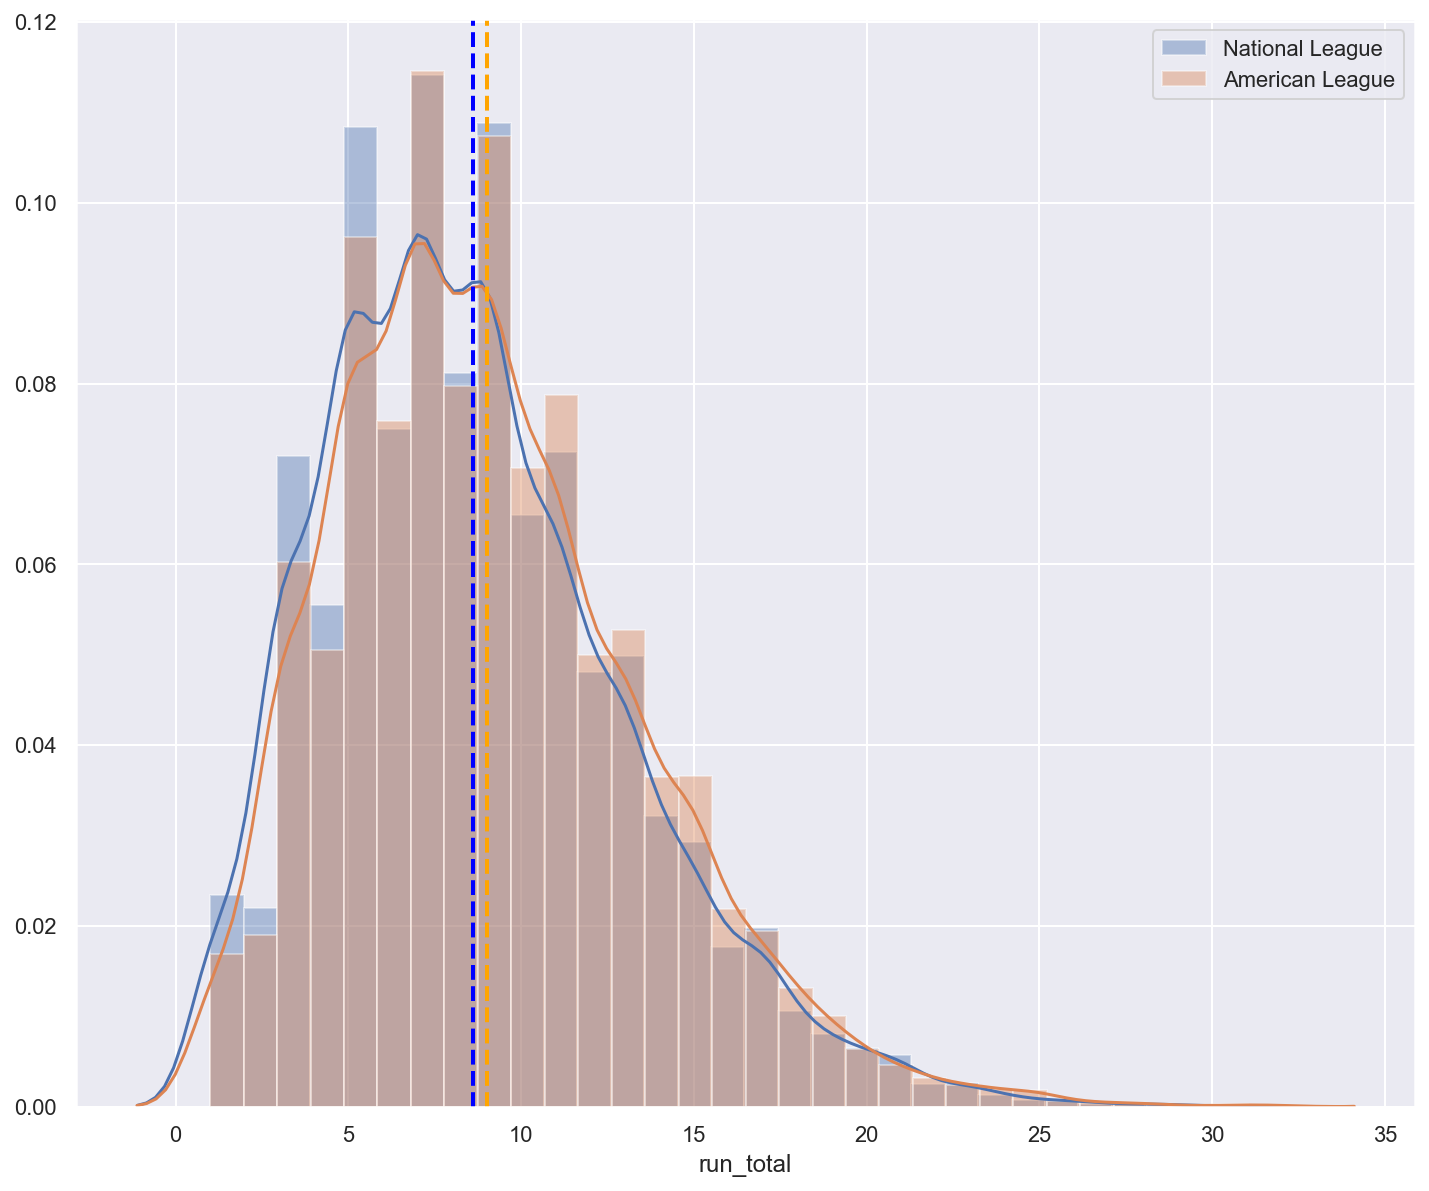

In [29]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(NL_runs,bins=NL_runs.max(),label='National League') # Blue distribution
sns.distplot(AL_runs,bins=AL_runs.max(),label='American League') # Orange distribution

plt.legend()

plt.axvline(NL_runs.mean(),color='blue', linestyle='--', lw=2)
plt.axvline(AL_runs.mean(),color='orange', linestyle='--', lw=2)

In [30]:
NL_skew = stats.skew(NL_runs)
AL_skew = stats.skew(AL_runs)
print('NL Runs Skew: ',NL_skew)
print('AL Runs Skew: ',AL_skew)

NL Runs Skew:  0.7606128171412102
AL Runs Skew:  0.7540337783692563


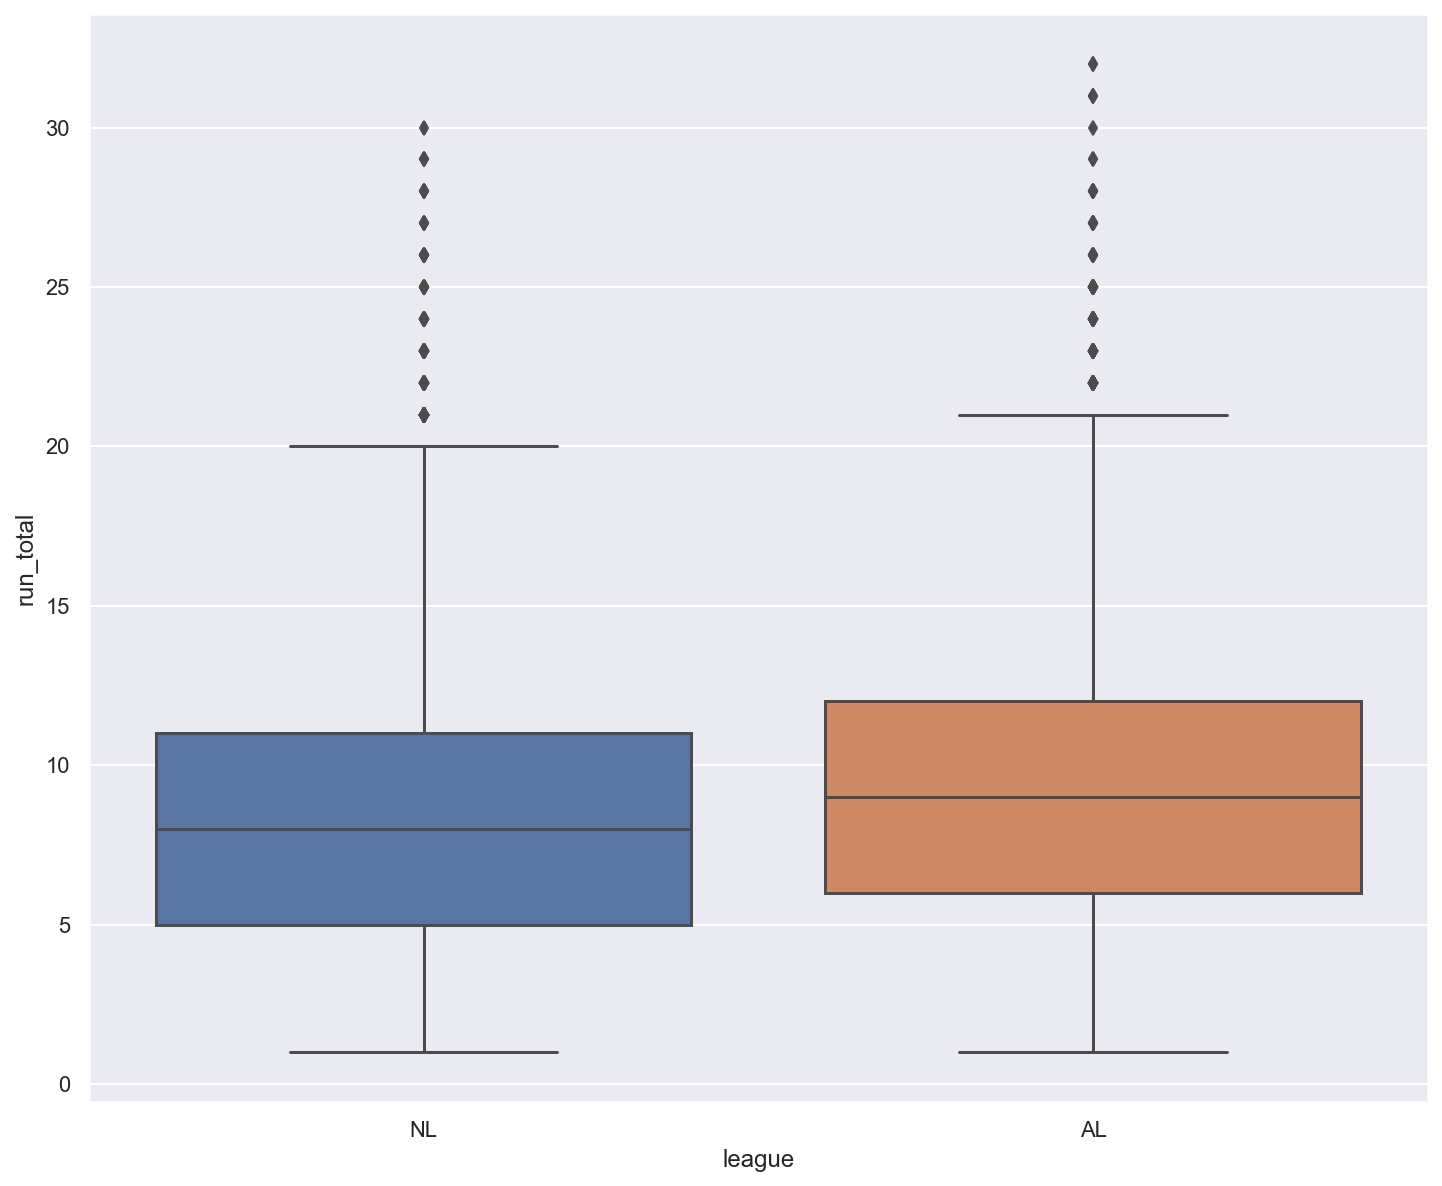

In [31]:
sns.boxplot(x=df['league'],y=df['run_total'],orient='v')

Now we calculate our Z statistic

In [46]:
AL_mean = np.mean(AL_runs)
NL_mean = np.mean(NL_runs)

NL_std = np.std(NL_runs)
AL_std = np.std(AL_runs)

NL_n = len(NL_runs)
AL_n = len(AL_runs)

numer = (AL_mean-NL_mean)
denom = np.sqrt((NL_std**2/NL_n)+(AL_std**2/AL_n))

Z = numer/denom
print('Z-Statistic: ',Z)

Z-Statistic:  7.308239840879552


With a Z-Statisic of 7.3, our P-Value is less than our pre-determined alpha. Therefore, we may reject the null hypothesis.

In [33]:
P_value = 1-stats.norm.cdf(Z)
print('P Value: ',P_value)

alpha = .001
print('P_value < alpha =',P_value < alpha)

P Value:  1.3533618670180658e-13
P_value < alpha = True


While our P-Value indicates that the population means are fundamentally different, the effect size as demonstrated by Cohen's D tells us that the magnitude of difference in population means is low.   

In [34]:
pooled_SD = np.sqrt((NL_std**2 + AL_std**2)/2)
cohens_d = (AL_mean - NL_mean)/pooled_SD
print("Cohen's D: ",cohens_d)

Cohen's D:  0.09009372728428088


### Summary of Results

- We can reject the Null Hypothesis
- Z-Score is about 7.3, P-Value is close to 0
- Effect size (determined with Cohen's D) is very small
- Results indicate a small, but statistically significant, difference in runs scored per game between leagues

## Second Test: Temperature vs. Runs Scored 

Our next hypothesis test will determine the effect of weather on runs scored per game. We wanted to see if temperature and total runs per game are correlated. 

##### To test correlation between temperature and runs scored, we employed a least-squares regression model.

- Null Hypothesis: The correlation between runs scored and temperature is 0
- Alt Hypothesis: The correlation between runs scored and temperature is not 0


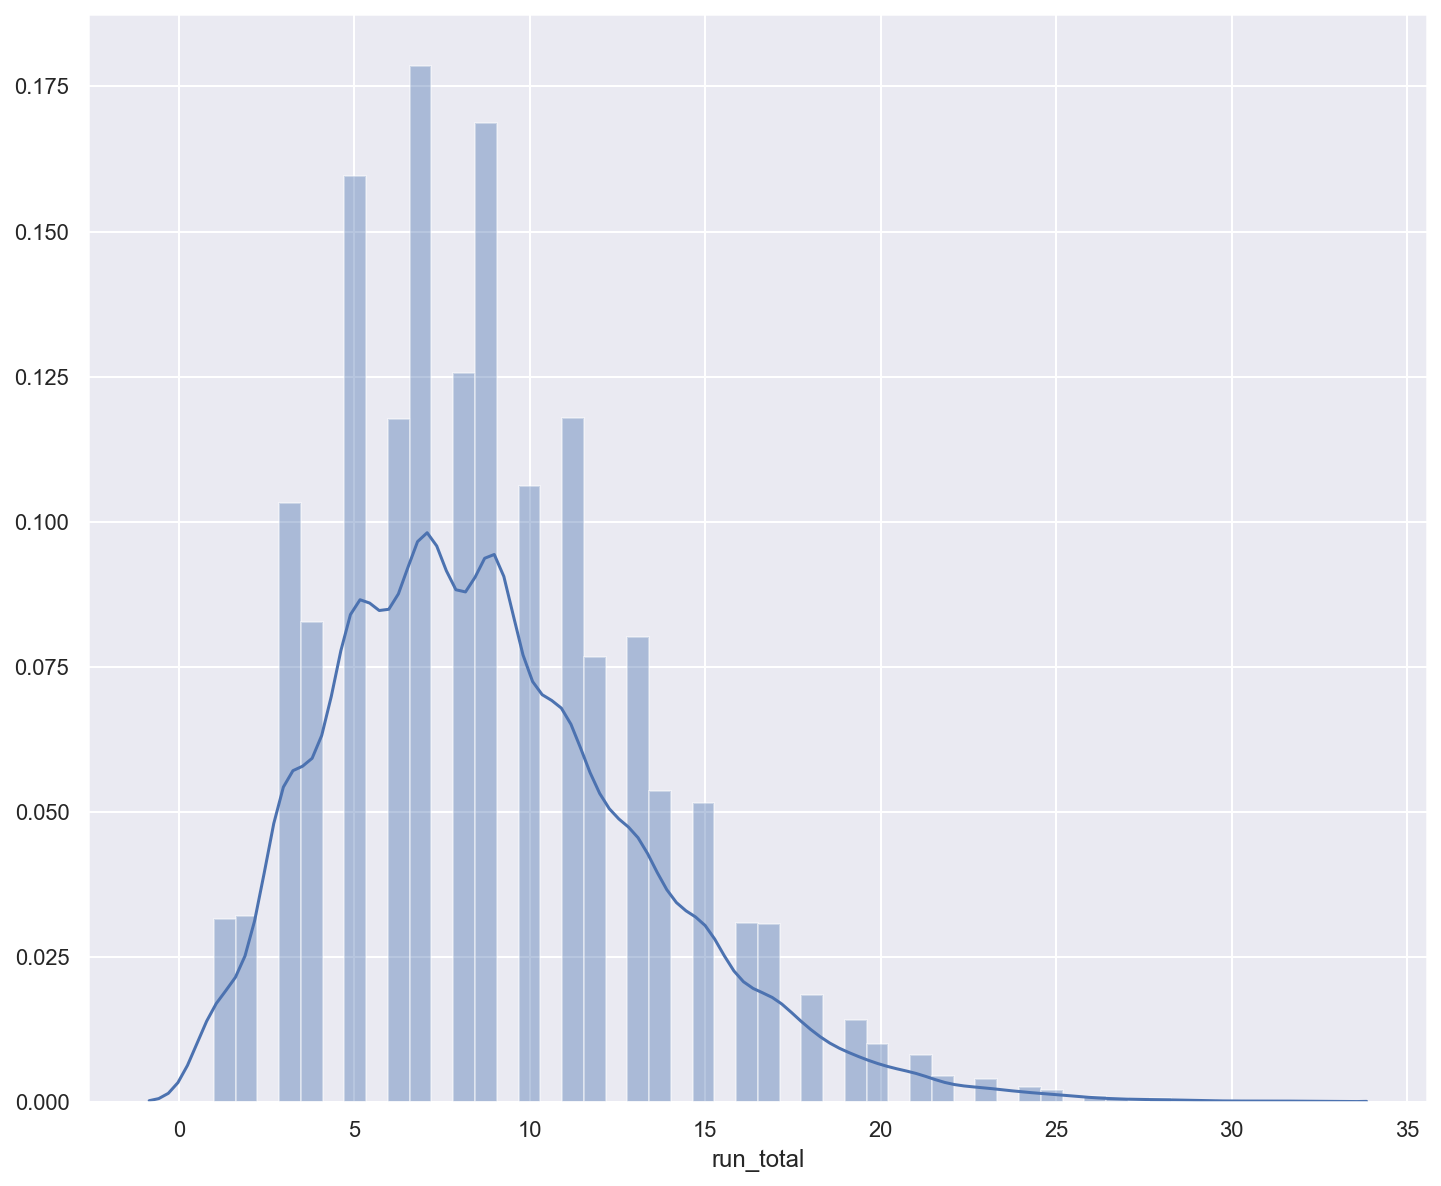

In [35]:
sns.distplot(df['run_total'])

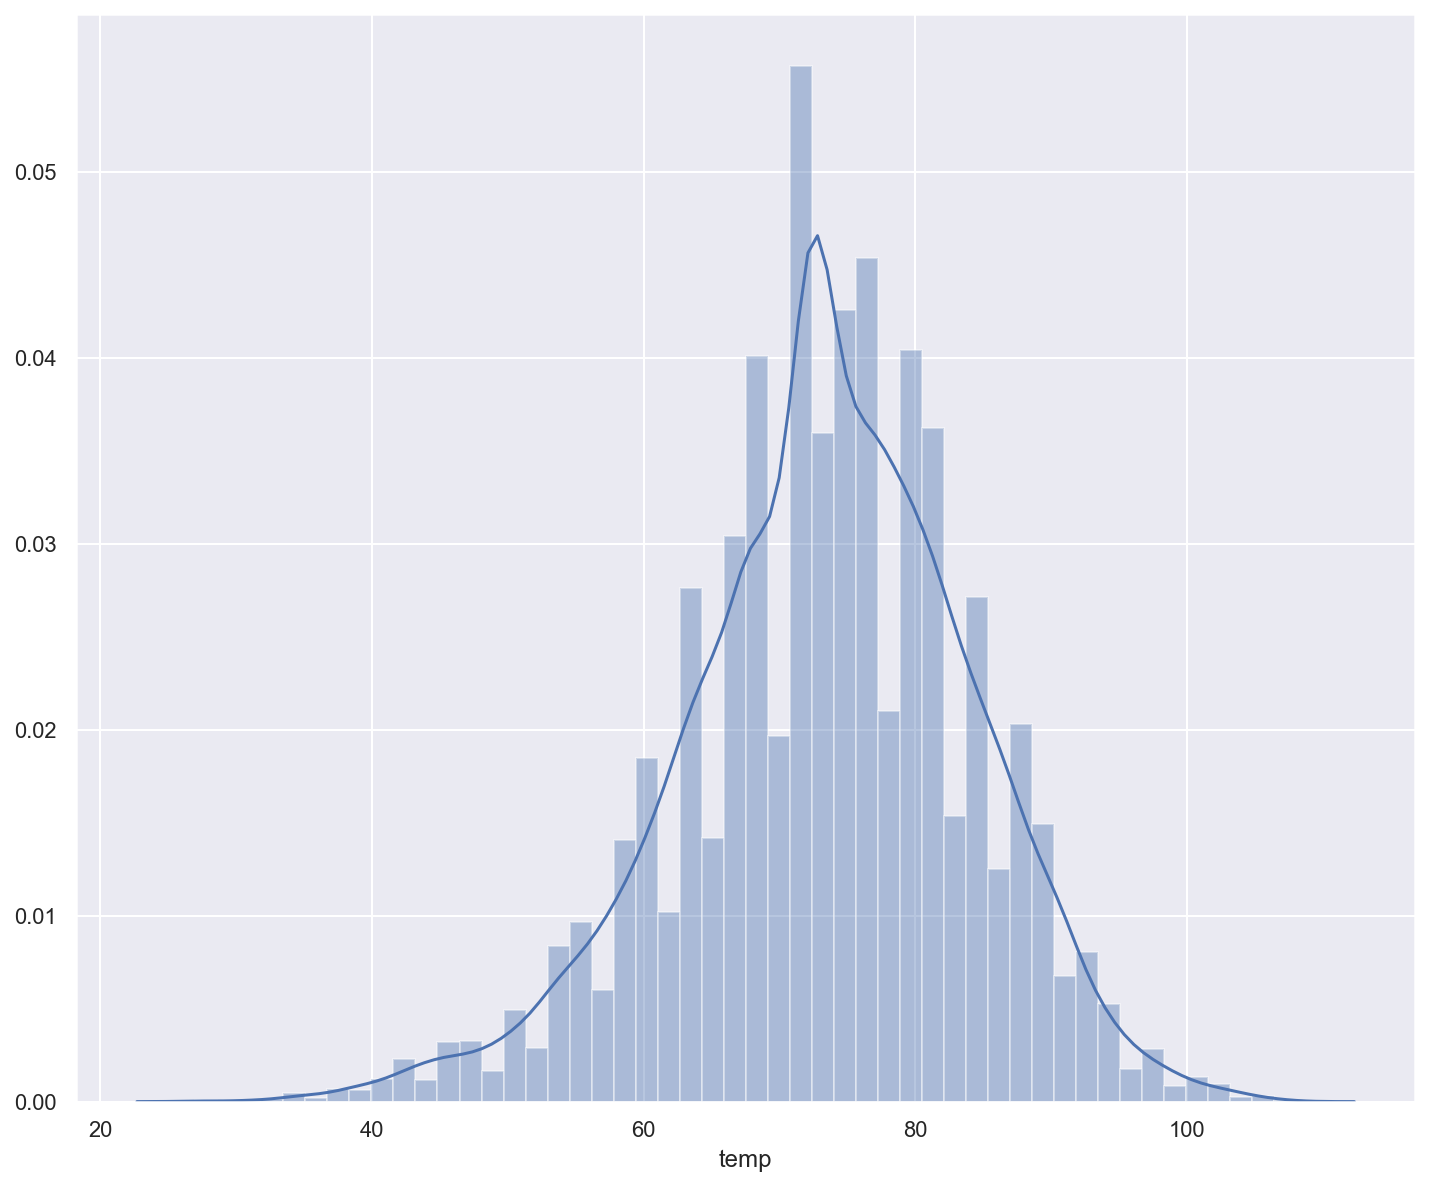

In [36]:
sns.distplot(df['temp'])

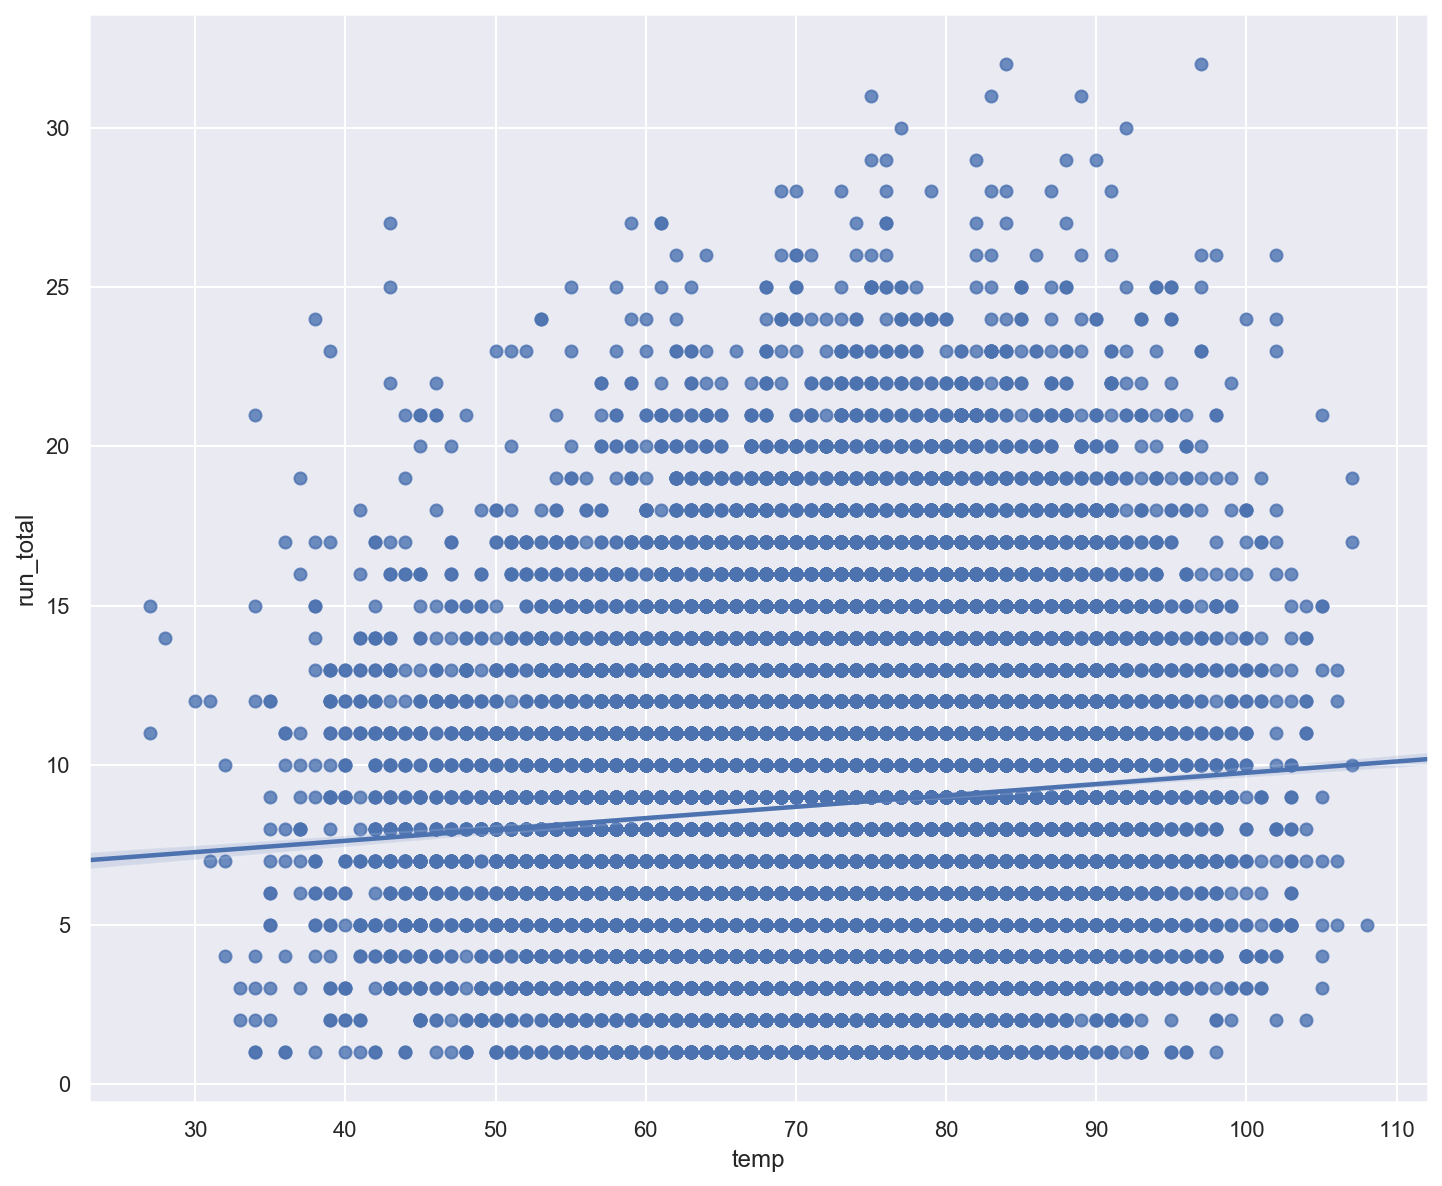

In [37]:
sns.regplot(df['temp'], df['run_total'])

In [47]:
temps = df['temp']
totals =df['run_total']

temp_std = np.std(temps)
total_std = np.std(totals)

temp_mean = np.mean(temps)
totals_mean = np.mean(totals)

temp_diff = temps - temp_mean
totals_diff = totals - totals_mean

covariance = np.sum(temp_diff * totals_diff)/len(totals_diff)
correl_coeff = covariance / (temp_std * total_std)

print('mean temp: ',temp_mean)
print('mean_runTotal: ',totals_mean)
print('covariance: ', covariance)
print('correlation coeffecient: ',correl_coeff)


mean temp:  73.33539759127693
mean_runTotal:  8.81254511606702
covariance:  4.107817017414246
correlation coeffecient:  0.08597103126740588


In [39]:
scipy_regression = stats.linregress(temps, totals)
scipy_regression

LinregressResult(slope=0.03554854117774998, intercept=6.205578715006845, rvalue=0.08597103126740015, pvalue=2.2803020585884567e-44, stderr=0.002539358717834214)

In [40]:
temps = sm.add_constant(temps)

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [41]:
model = sm.regression.linear_model.OLS(totals, temps)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              run_total   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     196.0
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           2.28e-44
Time:                        12:08:16   Log-Likelihood:                -76515.
No. Observations:               26321   AIC:                         1.530e+05
Df Residuals:                   26319   BIC:                         1.531e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2056      0.188     32.971      0.000       5.837       6.574
temp           0.0355      0.003     13.999      0.000       0.031       0.041
==============================================================================
Omnibus:                     2253.720   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2949.222
Skew:                           0.746   Prob(JB):                         0.00
Kurtosis:                       3.680   Cond. No.                         511.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Summary of Results

- With a large F-stat and low P-Value, we can confidently reject the null hypothesis
- An R-squared value of .007 reflects a small effect size
- The correlation is valid, but temperature does not greatly effect runs scored

## Third Test: Variance of Runs Scored by Stadium

Finally, we want to see how different stadiums effect runs scored.

##### We will use ANOVA testing to examine the variance in runs scored by stadium

- Null Hypothesis: the variances for runs scored by stadium are equal
- Alt Hypothesis: the variances for runs scored by stadium are not equal

In [42]:
# filter out stadiums with fewer that 238 games played
df_stadium = df.groupby('venue_name').filter(lambda x: len(x)>238)
stadiums = list(df_stadium['venue_name'].unique())

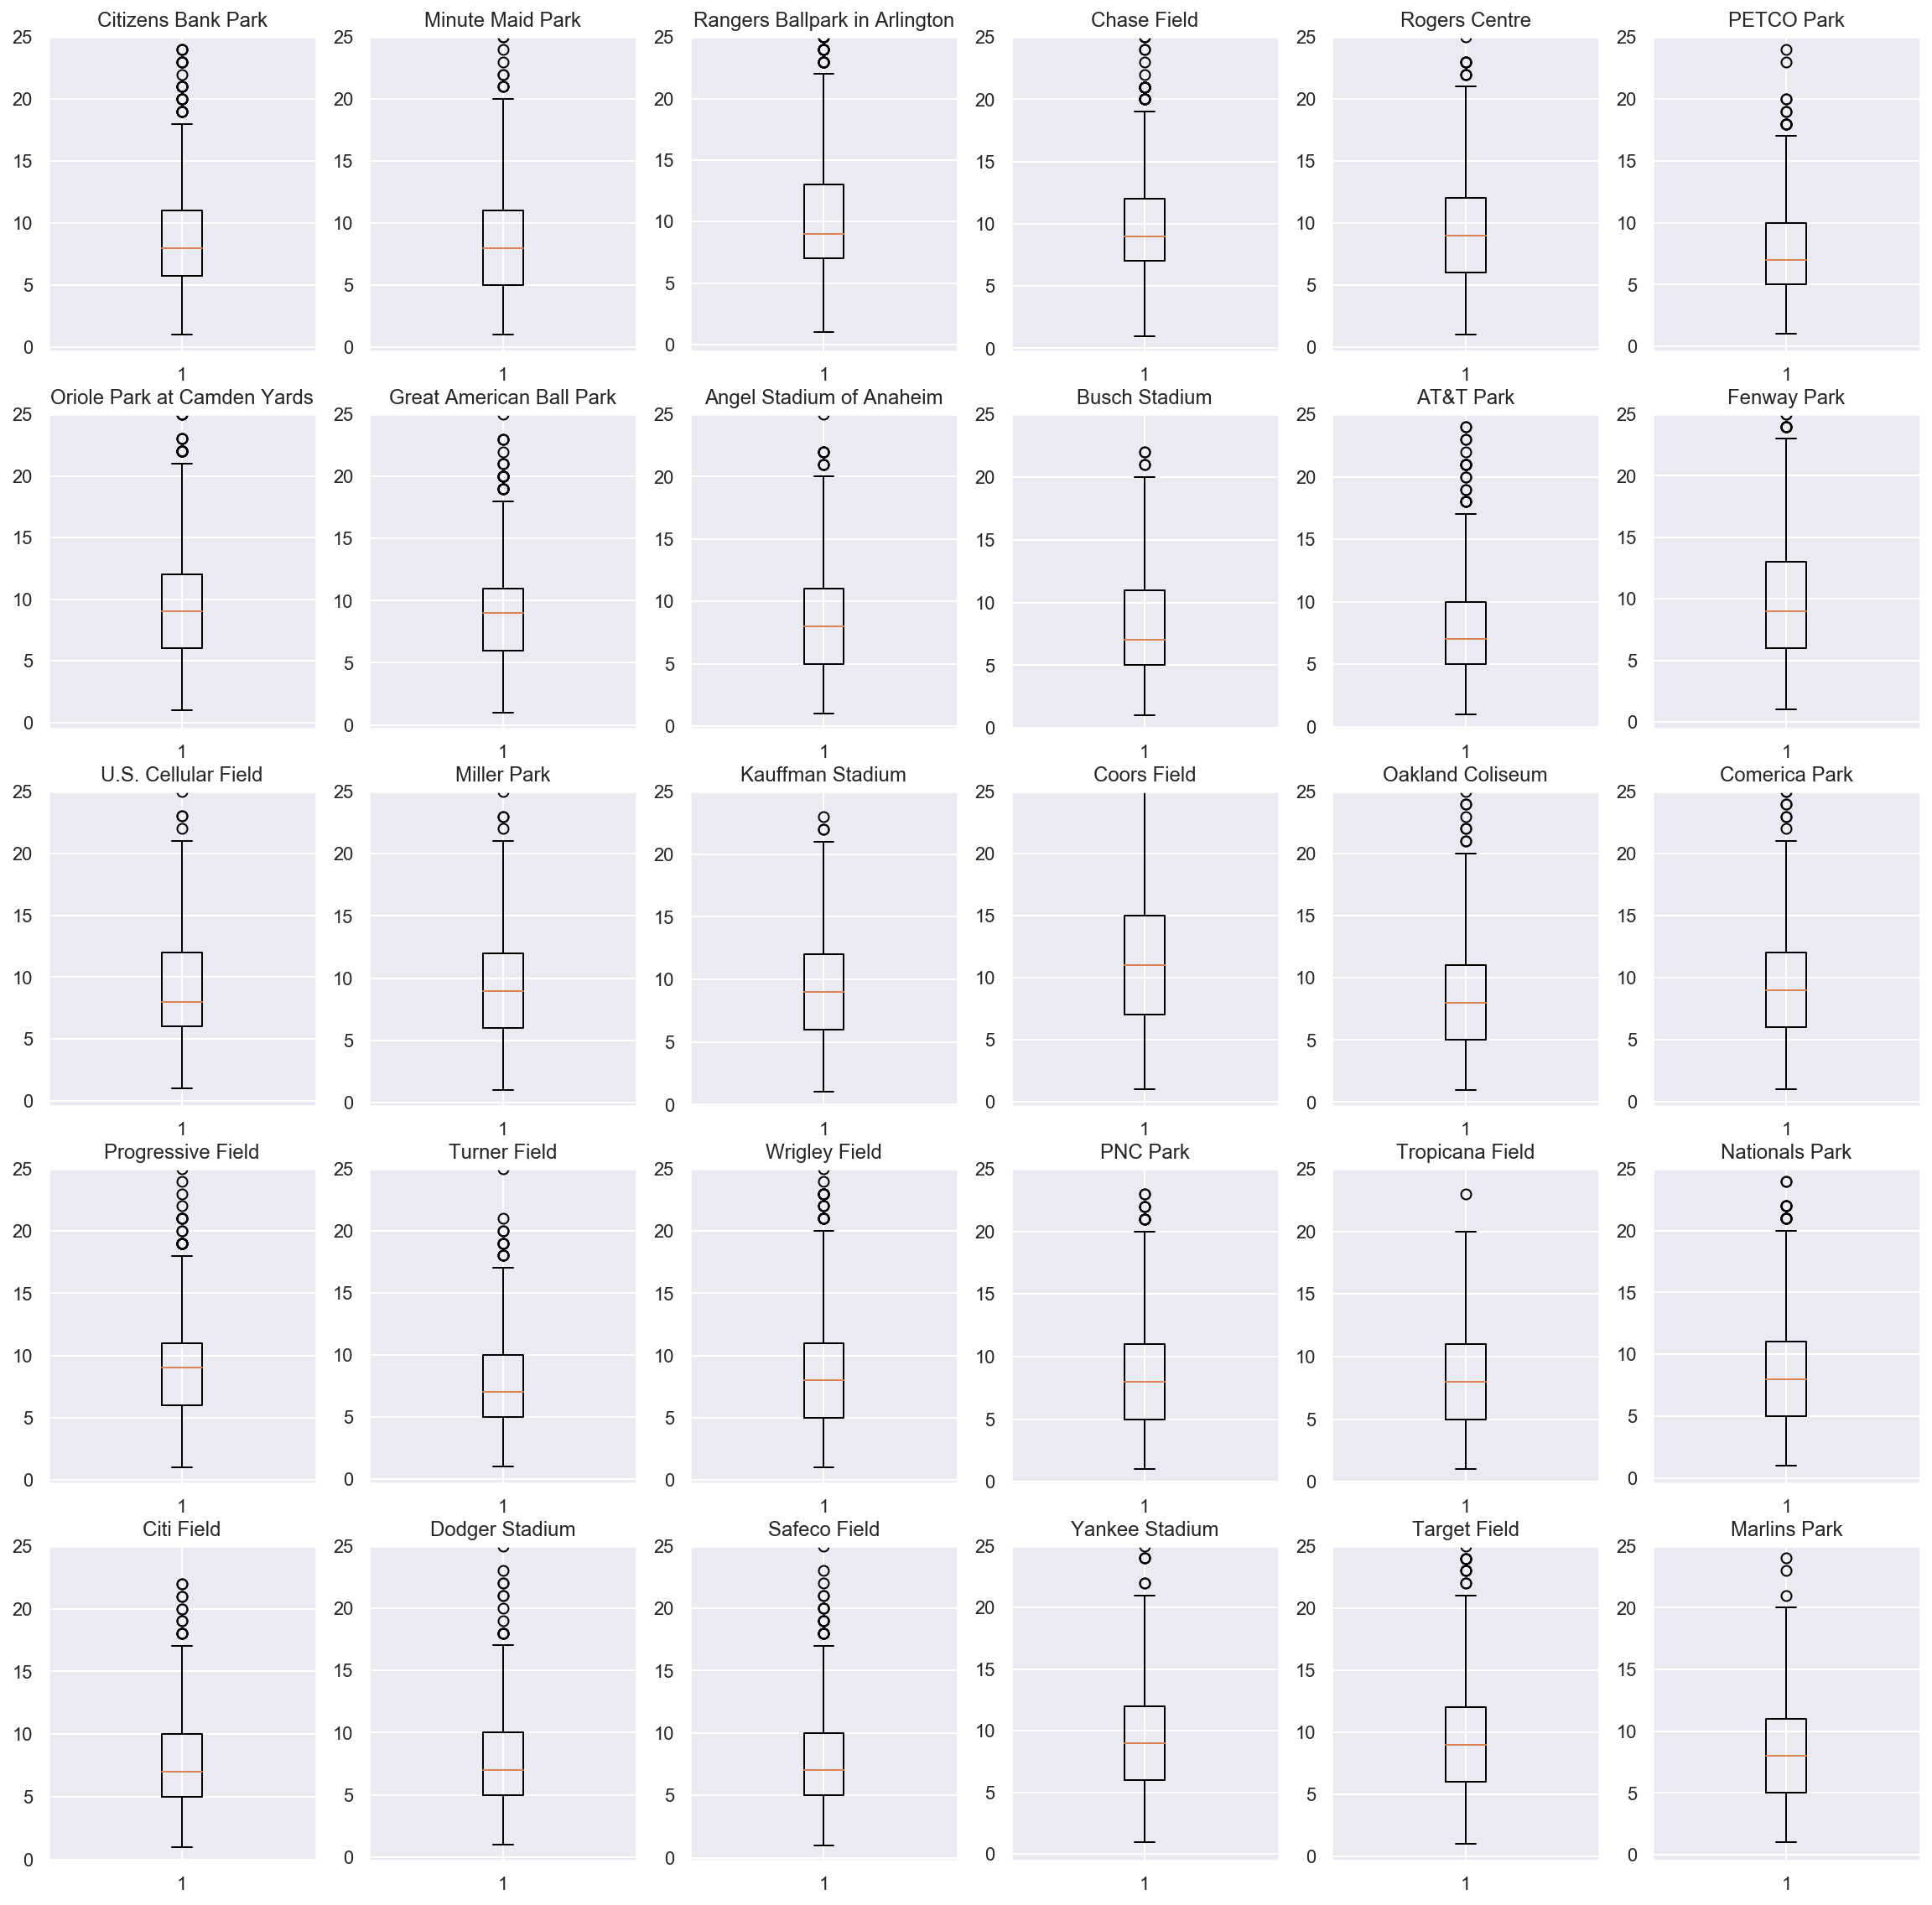

In [43]:
fig1, fig1_axes = plt.subplots(ncols=5,nrows=6,sharey='all',)
fig1.set_figheight(20)
fig1.set_figwidth(20)
for i in range(1,31):
    plt.subplot(5,6,i)
    plt.boxplot(df[df['venue_name']==stadiums[i-1]]['run_total'])
    plt.title(stadiums[i-1])
    plt.ylim(top=25)

In [48]:
formula = 'run_total ~ C(venue_name)'
lm = ols(formula, df_stadium).fit()
table = sm.stats.anova_lm(lm, typ=2)

In [49]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq']
    aov = aov[cols]
    return aov

anova_table(table)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq
C(venue_name),16606.663301,29.0,572.643562,29.968323,2.968909e-161,0.032694
Residual,491331.586864,25713.0,19.108295,NaN,NaN,NaN


### Summary of Results

- Again, a low P-Value for our F-Stat allows us to reject our Null Hypothesis
- We can conclude that the runs scored per game varies by stadium 
- The effect size, measured by eta_sq, is low